# Introduction

------------------------------
## Mission - Élaborez le modèle de scoring
------------------------------

Vous êtes Data Scientist au sein d'une société financière, nommée **"Prêt à dépenser"**, qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite **mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité** qu’un client rembourse son crédit, puis classifier la demande en crédit accordé ou refusé. Elle souhaite donc développer un **algorithme de classification** en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

**Votre mission :**
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.
* Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.

Michaël, votre manager, vous incite à sélectionner un ou des kernels Kaggle pour vous faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring. 

Voici le mail qu’il vous a envoyé.

*Bonjour,*

*Afin de pouvoir faire évoluer régulièrement le modèle, je souhaite tester la mise en œuvre une démarche de type MLOps d’automatisation et d’industrialisation de la gestion du cycle de vie du modèle.*

*Vous trouverez en pièce jointe **la liste d’outils à utiliser** pour créer une plateforme MLOps qui s’appuie sur des outils Open Source.* 

*Je souhaite que vous puissiez mettre en oeuvre au minimum **les étapes orientées MLOps** suivantes :* 
* *Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations*
* *Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking*
* *Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”*
* *Tester le serving MLFlow*
* *Gérer le code avec le logiciel de version Git*
* *Partager le code sur Github pour assurer une intégration continue*
* *Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud*
* *Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions*
 
*J’ai également rassemblé des conseils pour vous aider à vous lancer dans ce projet !*

*Concernant **l’élaboration du modèle** soyez vigilant sur deux points spécifiques au contexte métier :* 
* *Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, avec une méthode au choix*
* *Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)*
    * *Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP*
    * *Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)*
    * *En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy*
 
*D’autre part je souhaite que vous mettiez en œuvre une démarche d’élaboration des modèles avec **Cross-Validation et optimisation des hyperparamètres, via GridsearchCV ou équivalent.***

*Un dernier conseil : si vous obtenez des scores supérieurs au 1er du challenge Kaggle (AUC > 0.82), posez-vous la question si vous n’avez pas de l’overfitting dans votre modèle !*

*Vous exposerez votre **modèle de prédiction sous forme d’une API** qui permet de calculer la probabilité de défaut du client, ainsi que sa classe (accepté ou refusé) en fonction du seuil optimisé d’un point de vue métier.*

***Le déploiement de l’API** sera réalisée sur une plateforme Cloud, de préférence une solution gratuite.*

*Je vous propose d’utiliser un Notebook ou une application Streamlit pour réaliser en local  l’**interface de test de l’API**.*

*Bon courage !*

*Mickael*

# Import des librairies

In [1]:
## Global 
import os
import shutil
import time
from datetime import datetime
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Imbalanced learn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Scipy
from scipy.sparse import csr_matrix
from scipy.stats import randint, uniform

# Scikit-learn
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# LGBM
from lightgbm import LGBMClassifier

# MLFlow
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.transformers import generate_signature_output

# SHAP
import shap

# Optuna
import optuna

In [2]:
# Initialize sns
sns.set()

# Lecture du dataset

In [3]:
# Define the path to data
path = "./data/"
# List files in the data directory
file_list = os.listdir(path)
# Create an empty dict to store the file name as key and a DataFrame as value
df_dict = {}
# Create a list to store file names
filenames_list = []
# Go through the list and get the name of the file without extension
for file in file_list:
    # Get the name of the file and its extension
    name, extension = os.path.splitext(file)
    # Append the name of the file to the dedicated list
    filenames_list.append(name)
    # Exclude "HomeCredit_columns_description.csv" which is not usefull for our purpose
    if file != "HomeCredit_columns_description.csv":
        # Append the dataframe read to the list
        df_dict[name] = pd.read_csv(path+file)

# Préparation des données

Pour la préparation des données nous nous appuierons sur le kernel Kaggle suivant : <a href="https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script">LightGBM with Simple Features</a>

Au préalable, définissons une fonction nous permettant d'effectuer un OneHotEnconding sur les variables catégorielles.

Celle-ci nous retournera le dataframe modifié après l'encoding et une liste des nouvelles colonnes créées.

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encode(data, nan_as_category=True):
    # Store the name of original columns
    original_columns = list(data.columns)
    # Retrieve categorical columns
    categorical_columns = [col for col in data.columns if data[col].dtype == "object"]
    # Proceed with OneHotEncoding
    data = pd.get_dummies(data, columns=categorical_columns, dummy_na=nan_as_category)
    # List new columns
    new_columns = [c for c in data.columns if c not in original_columns]
    # Return the dataframe and the list of new columns
    return data, new_columns

Premièrement intéressons nous aux dataframes "application"

In [5]:
# Merge train and test dataframes
df = pd.concat([df_dict["application_train"], df_dict["application_test"]]).reset_index(drop=True)

# Remove XNA gender
df = df[df["CODE_GENDER"] != "XNA"]

# Binary encode two state categorical features
for binary_features in ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
    df[binary_features], uniques = pd.factorize(df[binary_features])
    
# OneHot Encode categorical features
df, applications_cat_cols = one_hot_encode(df, False)

# Replace 365243 by NaN in DAYS_EMPLOYED column
df.loc[df["DAYS_EMPLOYED"]==365243, ["DAYS_EMPLOYED"]] = np.nan

# Generate new features by calculating percentages
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# Delete unecessary variables to free up memory
del applications_cat_cols

A présent, intéressons nous aux dataframes "bureau" et "bureau_balance"

In [6]:
# OneHot Encode categorical features
df_dict["bureau"], bureau_cat_cols = one_hot_encode(df_dict["bureau"], True)

# OneHot Encode categorical features
df_dict["bureau_balance"], bureau_balance_cat_cols = one_hot_encode(df_dict["bureau_balance"], True)

# Aggregation of bureau_balance dataframe on SK_ID_BUREAU
aggregations = {
    "MONTHS_BALANCE": ["min", "max", "size"], 
}
for col in bureau_balance_cat_cols:
    aggregations[col] = ["mean"]
# Groupby "SK_ID_BUREAU"
bb_agg = df_dict["bureau_balance"].groupby("SK_ID_BUREAU").agg(aggregations)
# Rename columns
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Merge bureau and bureau_balance dataframes
bureau = df_dict["bureau"].join(bb_agg, how="left", on="SK_ID_BUREAU")
# Drop SK_ID_BUREAU column, which is a reference between bureau and bureau_balance dataframes
bureau.drop(["SK_ID_BUREAU"], axis=1, inplace= True)

# Aggregation of bureau dataframe
# Build numeric features in bureau dataframe
num_aggregations = {
    "DAYS_CREDIT": ["min", "max", "mean", "var"],
    "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
    "DAYS_CREDIT_UPDATE": ["mean"],
    "CREDIT_DAY_OVERDUE": ["max", "mean"],
    "AMT_CREDIT_MAX_OVERDUE": ["mean"],
    "AMT_CREDIT_SUM": ["max", "mean", "sum"],
    "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
    "AMT_CREDIT_SUM_OVERDUE": ["mean"],
    "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
    "AMT_ANNUITY": ["max", "mean"],
    "CNT_CREDIT_PROLONG": ["sum"],
    "MONTHS_BALANCE_MIN": ["min"],
    "MONTHS_BALANCE_MAX": ["max"],
    "MONTHS_BALANCE_SIZE": ["mean", "sum"],
}
# Build categorical features
cat_aggregations = {}
for cat in bureau_cat_cols: cat_aggregations[cat] = ["mean"]
for cat in bureau_balance_cat_cols: cat_aggregations[cat + "_MEAN"] = ["mean"]
# Groupby "SK_ID_CURR"
bureau_agg = bureau.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
# Rename columns
bureau_agg.columns = pd.Index(["BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

# Generate features for active credits
# Get all active credits
active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
# Groupby "SK_ID_CURR" with the same aggregations params for numerical features only
active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
# Rename columns
active_agg.columns = pd.Index(["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
# Join bureau_agg and active_agg dataframes
bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")

# Generate features for closed credits
# Get all closed credits
closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
# Groupby "SK_ID_CURR" with the same aggregations params for numerical features only
closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
# Rename columns
closed_agg.columns = pd.Index(["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
# Join bureau_agg and active_agg dataframes
bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")

# Join df and new bureau_agg dataframes
df = df.join(bureau_agg, how="left", on="SK_ID_CURR")

# Delete unecessary variables to free up memory
del bureau_cat_cols, bureau_balance_cat_cols, aggregations, bb_agg, \
    bureau, num_aggregations, cat_aggregations, bureau_agg, \
    closed, closed_agg

Passons au dataframe "previous_application"

In [7]:
# OneHot Encode categorical features
df_dict["previous_application"], prev_app_cat_cols = one_hot_encode(df_dict["previous_application"], True)

# Replace 365243 days by NaN 
df_dict["previous_application"].loc[
    df_dict["previous_application"]["DAYS_FIRST_DRAWING"] == 365243, ["DAYS_FIRST_DRAWING"] 
] = np.nan
df_dict["previous_application"].loc[
    df_dict["previous_application"]["DAYS_FIRST_DUE"] == 365243, ["DAYS_FIRST_DUE"] 
] = np.nan
df_dict["previous_application"].loc[
    df_dict["previous_application"]["DAYS_LAST_DUE_1ST_VERSION"] == 365243, ["DAYS_LAST_DUE_1ST_VERSION"] 
] = np.nan
df_dict["previous_application"].loc[
    df_dict["previous_application"]["DAYS_LAST_DUE"] == 365243, ["DAYS_LAST_DUE"] 
] = np.nan
df_dict["previous_application"].loc[
    df_dict["previous_application"]["DAYS_TERMINATION"] == 365243, ["DAYS_TERMINATION"] 
] = np.nan

# Add feature : value ask / value received percentage
df_dict["previous_application"]["APP_CREDIT_PERC"] = \
    df_dict["previous_application"]['AMT_APPLICATION'] / df_dict["previous_application"]["AMT_CREDIT"]

# Aggregation of previous_application dataframe
# Previous applications numeric features
num_aggregations = {
    "AMT_ANNUITY": ['min', 'max', 'mean'],
    "AMT_APPLICATION": ['min', 'max', 'mean'],
    "AMT_CREDIT": ['min', 'max', 'mean'],
    "APP_CREDIT_PERC": ['min', 'max', 'mean', 'var'],
    "AMT_DOWN_PAYMENT": ['min', 'max', 'mean'],
    "AMT_GOODS_PRICE": ['min', 'max', 'mean'],
    "HOUR_APPR_PROCESS_START": ['min', 'max', 'mean'],
    "RATE_DOWN_PAYMENT": ['min', 'max', 'mean'],
    "DAYS_DECISION": ['min', 'max', 'mean'],
    "CNT_PAYMENT": ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in prev_app_cat_cols:
    cat_aggregations[cat] = ["mean"]
# Groupby "SK_ID_CURR"
prev_agg = df_dict["previous_application"].groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
# Rename columns
prev_agg.columns = pd.Index(["PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Generate features for approved applications
# Get all approved applications
approved = df_dict["previous_application"][df_dict["previous_application"]["NAME_CONTRACT_STATUS_Approved"] == 1]
# Groupby "SK_ID_CURR" with the same aggregations params for numerical features only
approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
# Rename columns
approved_agg.columns = pd.Index(["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
# Join prev_agg and approved_agg dataframes
prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")

# Generate features for refused applications
# Get all refused applications
refused = df_dict["previous_application"][df_dict["previous_application"]["NAME_CONTRACT_STATUS_Refused"] == 1]
# Groupby "SK_ID_CURR" with the same aggregations params for numerical features only
refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
# Rename columns
refused_agg.columns = pd.Index(["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
# Join prev_agg and refused_agg dataframes
prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")

# Join df and new bureau_agg dataframes
df = df.join(prev_agg, how="left", on="SK_ID_CURR")

# Delete unecessary variables to free up memory
del prev_app_cat_cols, cat_aggregations, prev_agg, num_aggregations, \
    approved, approved_agg, refused, refused_agg

Au tour du dataframe "POS_CASH_balance"

In [8]:
# OneHot Encode categorical features
df_dict["POS_CASH_balance"], pos_cat_cols = one_hot_encode(df_dict["POS_CASH_balance"], True)

# Aggregation of POS_CASH_balance dataframe
# POS_CASH_balance numeric features
aggregations = {
    "MONTHS_BALANCE": ["max", "mean", "size"],
    "SK_DPD": ["max", "mean"],
    "SK_DPD_DEF": ["max", "mean"],
}
# POS_CASH_balance categorical features
for cat in pos_cat_cols:
    aggregations[cat] = ["mean"]
# Groupby "SK_ID_CURR"
pos_agg = df_dict["POS_CASH_balance"].groupby("SK_ID_CURR").agg(aggregations)
# Rename columns
pos_agg.columns = pd.Index(["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count POS CASH accounts
pos_agg["POS_COUNT"] = df_dict["POS_CASH_balance"].groupby("SK_ID_CURR").size()

# Join df and new pos_agg dataframes
df = df.join(pos_agg, how="left", on="SK_ID_CURR")

# Delete unecessary variables to free up memory
del pos_cat_cols, aggregations, pos_agg

Puis du dataframe "installments_payments"

In [9]:
# OneHot Encode categorical features
df_dict["installments_payments"], install_cat_cols = one_hot_encode(df_dict["installments_payments"], True)

# Percentage and difference paid in each installment (amount paid and installment value)
df_dict["installments_payments"]["PAYMENT_PERC"] = \
    df_dict["installments_payments"]["AMT_PAYMENT"] / df_dict["installments_payments"]["AMT_INSTALMENT"]
df_dict["installments_payments"]["PAYMENT_DIFF"] = \
    df_dict["installments_payments"]["AMT_INSTALMENT"] - df_dict["installments_payments"]["AMT_PAYMENT"]
# Days past due and days before due (no negative values)
df_dict["installments_payments"]["DPD"] = \
    df_dict["installments_payments"]["DAYS_ENTRY_PAYMENT"] - df_dict["installments_payments"]["DAYS_INSTALMENT"]
df_dict["installments_payments"]["DBD"] = \
    df_dict["installments_payments"]["DAYS_INSTALMENT"] - df_dict["installments_payments"]["DAYS_ENTRY_PAYMENT"]
df_dict["installments_payments"]["DPD"] = \
    df_dict["installments_payments"]["DPD"].apply(lambda x: x if x > 0 else 0)
df_dict["installments_payments"]["DBD"] = \
    df_dict["installments_payments"]["DBD"].apply(lambda x: x if x > 0 else 0)

# Aggregation of installments_payments dataframe
# installments_payments numeric features
aggregations = {
    "NUM_INSTALMENT_VERSION": ["nunique"],
    "DPD": ["max", "mean", "sum"],
    "DBD": ["max", "mean", "sum"],
    "PAYMENT_PERC": ["max", "mean", "sum", "var"],
    "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
    "AMT_INSTALMENT": ["max", "mean", "sum"],
    "AMT_PAYMENT": ["min", "max", "mean", "sum"],
    "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"],
}
# installments_payments categorical features
for cat in install_cat_cols:
    aggregations[cat] = ["mean"]
# Groupby "SK_ID_CURR"
ins_agg = df_dict["installments_payments"].groupby("SK_ID_CURR").agg(aggregations)
# Rename columns
ins_agg.columns = pd.Index(["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count POS CASH accounts
ins_agg["INSTAL_COUNT"] = df_dict["installments_payments"].groupby("SK_ID_CURR").size()

# Join df and new ins_agg dataframes
df = df.join(ins_agg, how="left", on="SK_ID_CURR")

# Delete unecessary variables to free up memory
del install_cat_cols, aggregations, ins_agg

Et enfin du dataframe "credit_card_balance"

In [10]:
# OneHot Encode categorical features
df_dict["credit_card_balance"], credit_cat_cols = one_hot_encode(df_dict["credit_card_balance"], True)

# General aggregations
df_dict["credit_card_balance"].drop(["SK_ID_PREV"], axis= 1, inplace = True)
cc_agg = df_dict["credit_card_balance"].groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
cc_agg.columns = pd.Index(["CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg["CC_COUNT"] = df_dict["credit_card_balance"].groupby("SK_ID_CURR").size()

# Join df and new cc_agg dataframes
df = df.join(cc_agg, how="left", on="SK_ID_CURR")

# Delete unecessary variables to free up memory
del credit_cat_cols, cc_agg

Supprimons les valeurs infinies

In [11]:
df = df.replace([np.inf, -np.inf], np.nan)

Remplaçons les variables pour lesquelles le type a été mal défini, ie les variables binaires encodées en object

In [12]:
for col in df.select_dtypes(include=["object"]).columns.to_list():
    df[col], uniques = pd.factorize(df[col])

Séparons à présent nos données en jeux d'entrainement et de test

In [13]:
# Divide in training/validation and test data
train_df = pd.DataFrame(df[df['TARGET'].notnull()])
test_df = pd.DataFrame(df[df['TARGET'].isnull()])

# Vérification des correlations

Vérifions qu'après la création de nos features, nous n'avons pas de correlations trop fortes avec notre cible, auquel cas ces variables seront analysées afin de se prémunir d'un data leakage éventuel.

In [14]:
# Compute pearson correlation matrix
#pearson = train_df.corr(method="pearson", numeric_only=True)

In [15]:
# Look for correlations or anti correlations with the target of more than 70%
#pearson["TARGET"].loc[(pearson["TARGET"] > 0.7) | (pearson["TARGET"] < -0.7)]

Aucune correlation ne semble trop importante avec notre cible !

# Métriques d'évaluation

Afin de nous adapter au mieux à la problématique métier, nous allons définir une fonction afin de calculer un "score métier".

En effet, il existe un déséquilibre du coût métier entre un faux négatif (un mauvais client prédit comme bon client : donc crédit accordé et perte de capital) et un faux positif (bon client prédit mauvais : refus de crédit et donc manque à gagner en marge). On suppose que le coût d'un faux négatif est 10 fois supérieur à celui d'un faux positif.

Pour cela, nous calculerons un "gain" que fera la société comme suit :
* les vrais positifs : les bons clients rapportent de l'argent et sont donc pondérés à 1
* les faux positifs : bon client refusé à tort, la banque ne gagne pas l'argent qu'elle aurait pu. Nous appliquerons une pondération de -1
* les faux négatifs : mauvais client : la banque perd l'argent du prêt, soit 10 fois plus que dans le cas d'un vrai positif. Nous appliquerons une pondération de -10
* les vrais négatifs ne rapportent pas d'argent et n'en font pas perdre non plus donc sont ignorés

Note : les coéfficients de pondération seront éventuellemnt à modifier selon les observations effectuées sur le comportement lors de l'entrainement des modèles.

In [16]:
def compute_business_score(y_true, y_pred, tp_coeff = 1, fn_coeff=-1, fp_coeff=-10):
    """
    Compute a business score to evaluate our models
    Goal : penalize false negative compared to false positive
    --------------------
    Arguments :
        y_true : array-like : correct values
        y_pred : array-like : predicted values
        tp_coeff : optionnal, float : coefficient to apply to true positive values
        fn_coeff : optionnal, float : coefficient to apply to false negative values
        fp_coeff : optionnal, float : coefficient to apply to false positive values
    --------------------
    """
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    score = tp_coeff*tp + fp_coeff*fp + fn_coeff*fn
    return score

Testons notre fonction avec plusieurs listes de valeurs :
* valeurs vraies : [0, 1, 1]
* introduction d'un faux positif : [1, 1, 1]
* introduction d'un faux négatif : [0, 1, 0]

In [17]:
# Define list of values
correct_values = [0, 1, 1]
false_positive_values = [1, 1, 1]
false_negative_values = [0, 1, 0]

# Compute scores
perfect_score = compute_business_score(correct_values, correct_values)
fp_score = compute_business_score(correct_values, false_positive_values)
fn_score = compute_business_score(correct_values, false_negative_values)

In [18]:
perfect_score

2

In [19]:
fp_score

-8

In [20]:
fn_score

0

On constate bien que notre score diminue fortement en présence d'un faux négatif comme attendu, à l'inverse du score avec un faux positif qui diminue nettement moins.

Associé à notre fonction métier, nous mettrons également en oeuvre les métriques d'évalutation suivantes :
* l'aire sous la courbe ROC
* le temps d'entrainement

In [21]:
# Defining scoring dict to apply in the models training
scoring = {
    "business": make_scorer(compute_business_score),
    "rocauc": make_scorer(roc_auc_score),
}

# Déséquilibre des classes

Analysons le déséquilibre des classes.

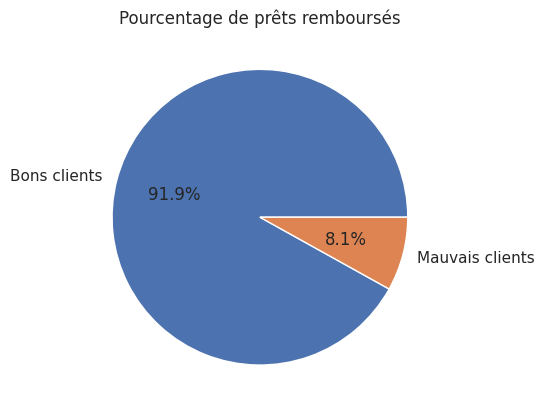

In [22]:
# Create a plot of the target classes
fig = plt.figure()
# Calculate the percentage of each class and plot it into a pie
plt.pie(train_df["TARGET"].value_counts()/train_df.shape[0]*100,
        autopct='%1.1f%%',
        labels=["Bons clients", "Mauvais clients"]
       )
plt.title('Pourcentage de prêts remboursés')
plt.show()

Comme spécifié, nous sommes face à un déséquilibre important des classes, nous devrons mettre en oeuvre une méthode de rééquilibrage afin d'élaborer un modèle pertinent.

Pour cela, nous allons utiliser une combinaison d'oversampling et d'undersampling. Pour l'oversampling, nous doublerons le nombre d'échantillons de la classe minoritaire pour atteindre une répartition de 80/20. Ensuite nous appliquerons l'undersampling pour avoir une répartition où le nombre d'échantillons de la classe minoritaire est deux fois moindre que celui de la classe majoritaire.

In [23]:
# Define our oversampling and undersampling objects
oversampler = SMOTE(sampling_strategy=0.2, k_neighbors=5, random_state=8)
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=8)

# Create a pipeline to manage balancing
balancer = Pipeline([
    ("imputer", SimpleImputer()),
    ("oversampler", oversampler),
    ("undersampler", undersampler)
])

In [24]:
# Split features and target
X_test_smote = train_df.drop("TARGET", axis=1)
y_test_smote = train_df["TARGET"]

# Rebalance classes
X_test_smote, y_test_smote = balancer.fit_resample(X_test_smote, y_test_smote)

# Print number of values for each classes 
y_test_smote.value_counts()

# Delete unecessary variables to free up memory
del X_test_smote, y_test_smote

Afin d'éviter tout risque de data leakage, nous implémenterons SMOTE dans un pipeline lors de la définition de nos modèles.

# Modélisation

Pour trouver le modèle présentant le plus d'intérêt et donc celui à optimiser, nous allons en mettre 3 à l'épreuve :
* tout d'abord un DummyClassifier afin d'avoir une baseline
* un LogisticRegression
* un LGBMClassifier

Pour chacun de ces modèles, nous définirons un pipeline comme suit :
* Rééquilibrage des classes
* Modèle

Le modèle sera évalué sur le scoring métier, néanmoins, nous calculerons l'aire sous la courbe ROC ainsi que le temps d'entrainement.

Pour cela, nous utiliserons une fonction qui nous permettra de faire une cross validation à l'aide d'un StratifiedKFold afin d'avoir plusieurs échantillons d'entrainement et de test.

In [25]:
# Select a sample of our dataframe
sampled_df = train_df.sample(n=50000)

# Split target and features
X = sampled_df.drop("TARGET", axis=1)
y = sampled_df["TARGET"]

In [26]:
# Set the MLflow tracking server URI
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Set the MLflow registry URI
mlflow.set_registry_uri("file:./mlruns")

# Create a new MLflow experiment
mlflow.set_experiment("Models optimizations")

2025/04/04 22:29:57 INFO mlflow.tracking.fluent: Experiment with name 'Models optimizations' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/793816252497484758', creation_time=1743798597483, experiment_id='793816252497484758', last_update_time=1743798597483, lifecycle_stage='active', name='Models optimizations', tags={}>

In [27]:
# Create a pipeline for each model we want to test
dummy_model = Pipeline([
    ("imputer", SimpleImputer()),
    ("oversampler", oversampler),
    ("undersampler", undersampler),
    ("scaler", StandardScaler()),
    ("model", DummyClassifier(random_state=8)),
])
log_reg_model = Pipeline([
    ("imputer", SimpleImputer()),
    ("oversampler", oversampler),
    ("undersampler", undersampler),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=8, n_jobs=-1)),
])
lgbm_model = Pipeline([
    ("imputer", SimpleImputer()),
    ("oversampler", oversampler),
    ("undersampler", undersampler),
    ("scaler", StandardScaler()),
    ("model", LGBMClassifier(random_state=8, n_jobs=-1, verbosity=-1)),
])
lgbm_model_sans_smote = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LGBMClassifier(random_state=8, n_jobs=-1, verbosity=-1)),
])

In [28]:
# Create dict for each hyperparameters to optimize to each model
dummy_params = {}
log_reg_params = {
    'model__C': lambda trial: trial.suggest_float('C', 1e-4, 10.0, log=True),
    'model__penalty': lambda trial: trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
    'model__l1_ratio': lambda trial: trial.suggest_float('l1_ratio', 0.0, 1.0),
    'model__max_iter': lambda trial: 2000,
    "model__solver": lambda trial: 'saga',
}
lgbm_params = {
    'model__class_weight': lambda trial: "balanced",
    'model__boosting_type': lambda trial: trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
    'model__learning_rate': lambda trial: trial.suggest_float('learning_rate', 0.01, 0.3),
    'model__num_leaves': lambda trial: trial.suggest_int('num_leaves', 15, 100),
    'model__max_depth': lambda trial: trial.suggest_int('max_depth', 3, 10),
    'model__min_child_samples': lambda trial: trial.suggest_int('min_child_samples', 10, 50),
    'model__subsample': lambda trial: trial.suggest_float('subsample', 0.5, 1.0),
    'model__colsample_bytree': lambda trial: trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'model__reg_alpha': lambda trial: trial.suggest_float('reg_alpha', 0.0, 1.0),
    'model__reg_lambda': lambda trial: trial.suggest_float('reg_lambda', 0.0, 1.0),
}

In [29]:
# Create a dictionnary for all of our models
models_dict = {
    "DummyClassifier": {
        "model": dummy_model,
        "params": dummy_params,
    },
    "LogisticRegression": {
        "model": log_reg_model,
        "params": log_reg_params,
    },
    "LGBMClassifier": {
        "model": lgbm_model,
        "params": lgbm_params,
    },
    "LGBMClassifier sans SMOTE": {
        "model": lgbm_model_sans_smote,
        "params": lgbm_params,
    },
}

In [33]:
# Create a dictionnary for all of our models
models_dict = {
    "LGBMClassifier": {
        "model": lgbm_model,
        "params": lgbm_params,
    },
    "LGBMClassifier sans SMOTE": {
        "model": lgbm_model_sans_smote,
        "params": lgbm_params,
    },
}

# Optuna 

Pour mettre en place optuna, nous allons définir un certain nombre de mécanisme :
* tout d'abord nous allons configurer optuna pour ne logguer que les erreurs afin de ne pas être submergé d'informations
* ensuite nous définirons une fonction permettant de nous alerter lorsqu'un essai aura des résultats qui améliorent les résultats précédents

In [30]:
# Override optuna's default logging to CRITICAL only
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# Define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'
def champion_callback(study, frozen_trial):
  """
  Logging callback that will report when a new trial iteration improves upon existing
  best trial values.
  """
  winner = study.user_attrs.get("winner", None)

  if study.best_value and winner != study.best_value:
      study.set_user_attr("winner", study.best_value)
      if winner:
          improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
          print(
              f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
              f"{improvement_percent: .4f}% improvement"
          )
      else:
          print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [31]:
def compute_model_scores(model, param_grid, model_name, features, target, scoring):
    """
    Create folds in the data to make a cross_validation when training the model
    --------------------
    Arguments :
        model : Pipeline : pipeline of the model to train and evaluate
        param_grid : dict : the list of parameters to apply to the model
        model_name : str : the name of the model
        features : array-like of shape (n_samples, n_features) : training data
        target : array-like of shape (n_samples,) : target variable
        scoring : dict: the scoring dict
    --------------------
    """
    def objective(trial):
        # Train model with MLflow tracking
        with mlflow.start_run(nested=True):
            # Evaluate each lambda to obtain the different parameters
            params = {param: param_fn(trial) for param, param_fn in param_grid.items()}
        
            # Implement the StratifiedKFold
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)
            # Split the data
            split = skf.split(features, target)
            
            # Use cross_validate to find best parameters
            model.set_params(**params)
            scores = cross_validate(
                model, features, target, cv=skf, scoring=scoring, return_train_score=True
            )
    
            # Infer the model signature
            signature = infer_signature(
                model_input=features, params=params,
            )
    
            # Set tags of the model
            mlflow.set_tag("model", model_name)
            mlflow.set_tag("mlflow.runName", f"{model_name}_{datetime.now().strftime("%Y%m%d%H%M%S")}")
            mlflow.set_tag("search_method", "Optuna")
            
            # Log the best params found
            mlflow.log_params(params)
    
            # Get metrics
            fit_time = scores["fit_time"].mean()
            train_business = scores["train_business"].mean()
            test_business = scores["test_business"].mean()
            train_rocauc = scores["train_rocauc"].mean()
            test_rocauc = scores["test_rocauc"].mean()
            
            # Log metrics
            mlflow.log_metric("fit_time", fit_time)
            mlflow.log_metric("train_business", train_business)
            mlflow.log_metric("test_business", test_business)
            mlflow.log_metric("train_ROCAUC", train_rocauc)
            mlflow.log_metric("test_ROCAUC", test_rocauc)
    
            # Log the model
            mlflow.sklearn.log_model(
                sk_model=model, 
                artifact_path=model_name,
                signature=signature,
                registered_model_name=model_name
            )

        return test_business
    return objective

In [ ]:
for name, infos in models_dict.items():
    with mlflow.start_run(run_name=name, nested=True):
        objective = compute_model_scores(infos["model"], infos["params"], name, X, y, scoring)
        study = optuna.create_study(direction="maximize")
        if name == "DummyClassifier":
            n_trials=1
        else: n_trials=50
        study.optimize(objective, n_trials=n_trials, callbacks=[champion_callback])

        mlflow.log_params(study.best_params)
        mlflow.log_metric("best_business", study.best_value)

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'LGBMClassifier'.
Created version '1' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084247 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/75b6b60fe61e47268e0ee377dcb340aa
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758
Initial trial 0 achieved value: -4841.8


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '2' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084355 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/a9347ad69e0d43caaaf182663e693476
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '3' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084505 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/359ce033a966417f9e3b24aad3134de7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '4' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084604 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/65887e79c8d8497bb52280eacadc2843
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '5' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084723 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/d3701a3f0e054f35b752ddd92b6064d2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758
Trial 4 achieved value: -3818.4 with -26.8018% improvement


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '6' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084834 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/414edb49a9984928b1bb854d4d385829
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '7' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405084926 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/623a1f99945c4a728f8f8ae831cadefa
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '8' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085023 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/c54824e9b2e2436aad9bcb728ce6a46b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '9' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085122 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/8bfe71ec4e444c4e83a2c88154ae02ac
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '10' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085235 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/5d93ca5bed49489cac7c31fbee31c7a3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758
Trial 9 achieved value: -3772.8 with -1.2087% improvement


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '11' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085349 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/e844ff43c82d4161bb60a285c25bb8a8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758
Trial 10 achieved value: -3686.0 with -2.3549% improvement


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '12' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085503 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/d915d2ab7cb6433cad18052491e5d8e3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '13' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085618 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/f65d24b923094f068e6f1e22439d1beb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '14' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085729 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/6530072dcaee47d593d47ab836c01187
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '15' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085816 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/d93b07b969c24f9185587961e68a82c0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '16' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405085949 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/c4c951f1f8634fd09910244202aa5266
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '17' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090107 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/42286a272a8a42ee83d8f3c3779539e4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '18' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090228 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/7e52a8a098134e9d99df3431126bdf93
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '19' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090351 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/ae1ecbd229744044b652f526f8648baf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758
Trial 18 achieved value: -3472.6 with -6.1453% improvement


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '20' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090522 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/2edf9e15f1544722a9d274795c68ccbf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '21' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090638 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/d324a77d38d6495bae09766cf861e5f0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '22' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090813 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/72a3efb6bf7e4a29b79b979ba828a1c8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '23' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405090944 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/4e77e3cd7c61460fb32caf219fcfabda
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '24' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091111 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/c344342d5d464a98ad7d1d9cf50653f1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '25' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091218 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/8dd8537c89174fe39d73713bbe1a236e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '26' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091338 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/eadca882a86e463f9c74874b6f77b3fe
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '27' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091512 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/6cd17969705c4500a64d20b4612004ba
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '28' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091645 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/4bfcd0a31e584061a814c3382e59f7cd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '29' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091812 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/b4177c53977e4f47952af298e362ecfc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '30' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405091929 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/b5d3d25e78d14b189bdd32e8e3746eaa
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '31' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405092100 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/8524626b5267462c9ab4c4c3878b89c6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '32' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405092230 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/d8397bde9c374b679eab51ca93293813
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '33' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405092406 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/656d42795cd54580ba23d703fa6de185
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '34' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405092553 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/7360cf2e15e54cc09fb913b70882a962
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '35' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405092729 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/761d4b77e3224103b705c622dd4bd9bf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '36' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405092911 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/c754a64c66034552b1ef4e4935622d6e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '37' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405093021 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/ec0baf05121243b7ac37886768e16b9f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '38' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405093204 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/365927bb73c64941b7d1becf48934e58
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '39' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405093305 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/829870eea00c45658989cc32852a5ed8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
Created version '40' of model 'LGBMClassifier'.


🏃 View run LGBMClassifier_20250405093430 at: http://127.0.0.1:8080/#/experiments/793816252497484758/runs/3def6c78670045809cc8c39c6e128059
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/793816252497484758


# Feature importance